# Aerial image classification

Adrian Buzatu, 16 Nov 2020

Classification of images taken from the Sentinel-2 satellites in the RGB format, in order to classify images based on 10 classes on land usage or land occupation. 

The data is open sources from ESA (Eurosat) and will continue to come for free for the next 20-30 years, covering areas of almost all the European countries. Therefore it is worth building real-life applications for Europe. The data comes in 13 EM bands, including visible, near infrared (NIR), short wave infrared (SWIR).

The repeat-cycle is 5 days. By inferring on new data for the next 30 years, one use case is to detect changes in land-use, such as identifying cases of deforestation, desertification, urban and industrial expansion. 

But first, one must build the image classifier. For that, one needs a labeled dataset. These are hard to come by in general. This is why researchers from EuroSAT in Europe have labeled by hand about 27k images in 10 classes of land use, with about 2-3k images per class, and made it available on [GitHub](https://github.com/phelber/EuroSAT) and described in this open source [paper](file:///Users/abuzatu/Downloads/eurosat_paper.pdf). The 10 classes are: 

* Industrial Buildings

* Residential Buildings

* Annual Crop (cereals, sunflower, etc)

* Permanent Crop (orchards, vinyards, olive trees, etc)

* River

* Sea & Lake

* Herbaceous Vegetation

* Highway

* Pasture

* Forest

The dataset is available in both only RGB, or all the full spectrum. In this project we use the RGB dataset.

Each image has 64x64 pixels and a resolution of about 10 meters. Usually government regulations like GDPR or national security come into play, as at resolutions < 1 m, as then one can monitor the activitity of individual persons. 

Given that training a dataset is very computing intensive (usually parallel computing on GPUs is required), it is best to start on a pre-trained compute vision model based on a convolutional neural network (CNN). And then add a few more layers specific to our problem and train some more epochs to learn the details of the new data. This procedure is called transferred learning.

CNNs have proved the best algorithms for image classification. Yet, they still suffer from a problem called "vanishing gradient problem". In NNs in general learning is done from back propagation from the last layer to the first layer. For deep NNs with many layers, like the CNNs, weights on the first layers end up barely changing. This problem was solved by a particular type of CNNs that builds residual layers in the Res-Net50 CNN. This has also been pre-trained on a public dataset of images and is available in the TensorFlow. 

Res-Net50 is a Residual Neural Network with 50 layers. Identity connectors make a NN a residual NN. The input is taken directly at the end of each residual block. There are 5 residual blocks. Each block has 3 layers with 1x1 and 3x3 convolutions. Each layer is feed in both the next layer and in the layers about 2-3 positions ahead, called identify connections. Res-Net50 is is trained on 1000 categories from the ImageNet database. It has about 23 million trainable parameters. 

So we will start with Res-Net50, apply transfer learning and add more layers and train some more epochs. 

In [1]:
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
print(tf.__version__)

2.3.0


In [3]:
print(keras.__version__)

2.4.3


In [4]:
INPUT_FOLDER_NAME = "./data/2750"
OUTPUT_FOLDER_NAME = "./output"
MODEL_FILE_NAME = f"{OUTPUT_FOLDER_NAME}/model.h5"

In [5]:
IMAGE_HEIGHT = 64 # number of x rows, or N, in a matrix of NxM
IMAGE_WIDTH = 64 # number of y rows, or M, in a matrix of NxM
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NB_COLOR = 3 # 3 for RGB
SHUFFLE = True

In [6]:
image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, NB_COLOR)

In [7]:
# logging level: NOTSET, DEBUG, INFO, WARNING, ERROR, CRITICAL
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# 1. Load the dataset

https://www.tensorflow.org/tutorials/load_data/images

Load and split in train (80%) and validation (20%).

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    INPUT_FOLDER_NAME, labels='inferred', label_mode='int', class_names=None,
    color_mode='rgb', batch_size=BATCH_SIZE, image_size=image_size, shuffle=SHUFFLE, seed=42,
    validation_split=VALIDATION_SPLIT, subset="training", interpolation='bilinear', follow_links=False
)
train_ds

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    INPUT_FOLDER_NAME, labels='inferred', label_mode='int', class_names=None,
    color_mode='rgb', batch_size=BATCH_SIZE, image_size=image_size, shuffle=SHUFFLE, seed=42,
    validation_split=VALIDATION_SPLIT, subset="validation", interpolation='bilinear', follow_links=False
)
valid_ds

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

In [10]:
list_class_name = train_ds.class_names
list_class_name

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [11]:
num_classes = len(list_class_name) 
num_classes 

10

In [12]:
type(train_ds.take(1)) # this is how to take one batch of images

tensorflow.python.data.ops.dataset_ops.TakeDataset

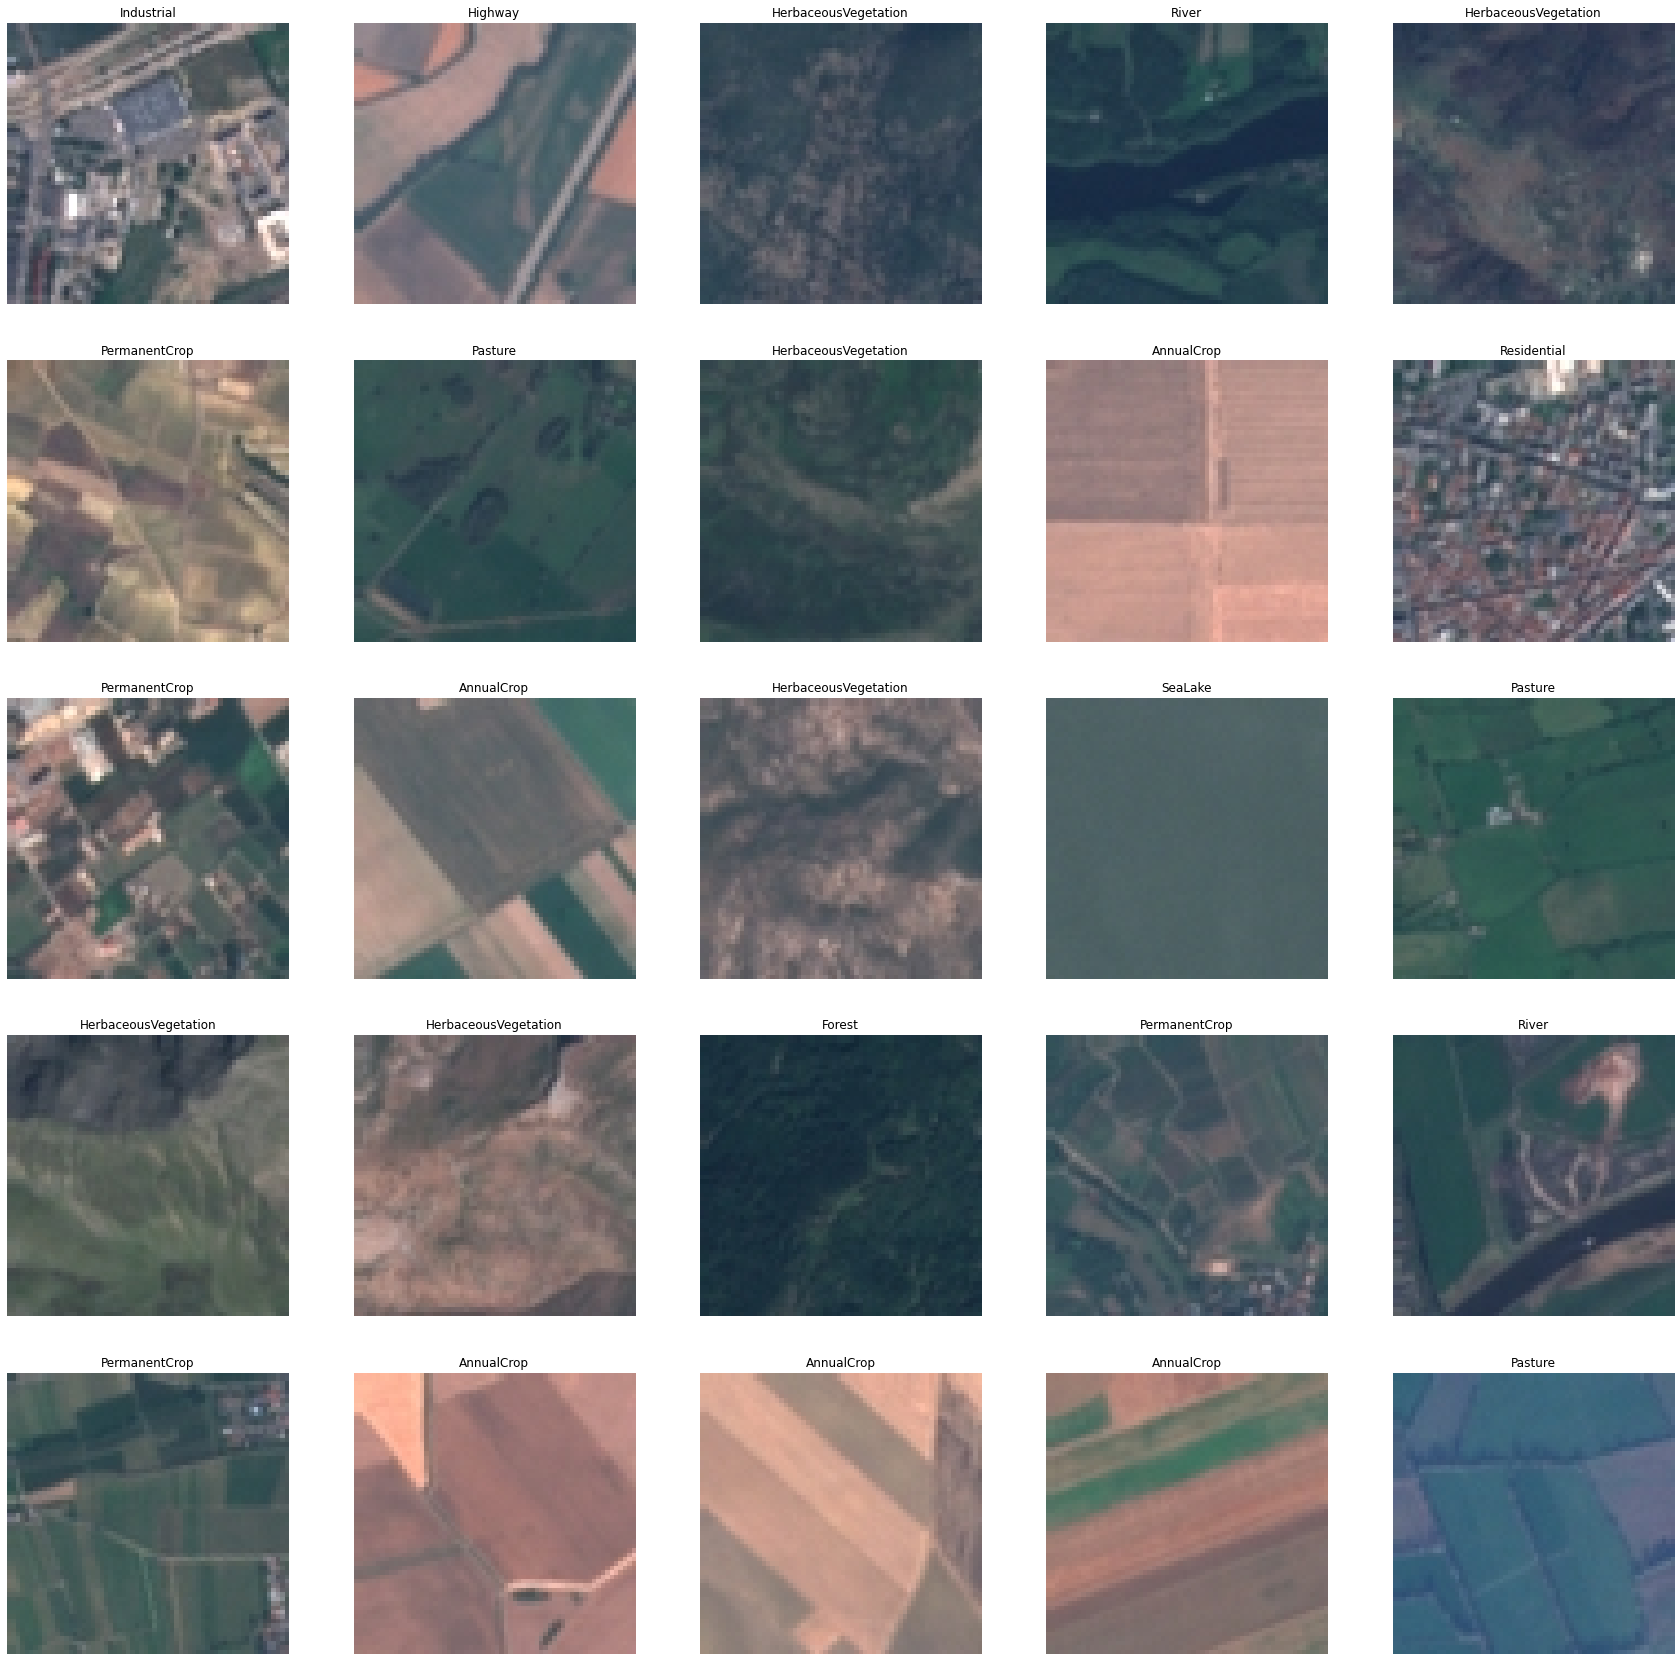

In [13]:
for batch_image, batch_label in train_ds.take(1):
    # take first 9 images
    fig, ax = plt.subplots(figsize=(30, 30))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(batch_image[i].numpy().astype("uint8"))
        plt.title(list_class_name[batch_label[i]])
        plt.axis("off")

## 2.1 Standardize the dataset

The color RGB are integers from 0 to 255. Let's convert instead in floats between 0.0 and 1.0.

We will build a normalization layer, which we will use inside our model to simplify deployment of our model to production.

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

## 2.2 Configure the dataset for performance

The dataset is large, so create a cache in computer memory at the first epoch, to be used for the following epochs. If the dataset is too large to fit in memory, this creates a powerful on-disk cache.

For training it overlaps the model pre-processing and execution.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 2.3 Data augmentation

The training dataset is not that large, so we can up-sample by introducing small translations or rotations to the current images. 

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

One image modified through augmentation

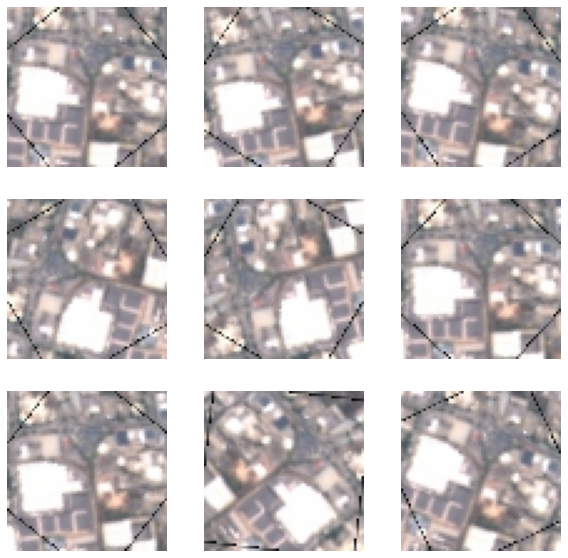

In [17]:
for image, sample in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# 3 Create the un-trained model

## 3.1 Create the base model from Res-Net50

We start with the weights that are already trained on many images by Res-Net50, to do transfer learning. 

We set `include_top=False` to not include the final pooling and fully connected layer in the original model to allow us to add our own layers at the end.

In [18]:
base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable=False

## 3.2 Create the model geometry and tell it how to learn (compile)

In [19]:
model = get_model(input_shape, data_augmentation, normalization_layer, base_model, num_classes)

INFO:root:None


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

# 4. Train the model

## 4.1 Train

In [20]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=10,
)

Epoch 1/10
675/675 [==============================] - 137s 203ms/step - loss: 1.7478 - accuracy: 0.7138 - val_loss: 1.7181 - val_accuracy: 0.7426
Epoch 2/10
675/675 [==============================] - 132s 196ms/step - loss: 1.7074 - accuracy: 0.7534 - val_loss: 1.7263 - val_accuracy: 0.7335
Epoch 3/10
675/675 [==============================] - 135s 200ms/step - loss: 1.6499 - accuracy: 0.8112 - val_loss: 1.6335 - val_accuracy: 0.8272
Epoch 4/10
675/675 [==============================] - 136s 201ms/step - loss: 1.6306 - accuracy: 0.8300 - val_loss: 1.6432 - val_accuracy: 0.8172
Epoch 5/10
675/675 [==============================] - 136s 202ms/step - loss: 1.6262 - accuracy: 0.8343 - val_loss: 1.6296 - val_accuracy: 0.8311
Epoch 6/10
675/675 [==============================] - 148s 219ms/step - loss: 1.5770 - accuracy: 0.8839 - val_loss: 1.5706 - val_accuracy: 0.8893
Epoch 7/10
675/675 [==============================] - 145s 215ms/step - loss: 1.5587 - accuracy: 0.9024 - val_loss: 1.5575 -

## 4.2 Evaluate the performance of the training

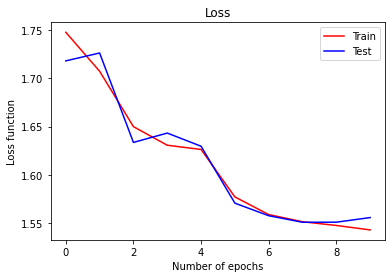

In [21]:
plt.plot(history.history["loss"], color = "red", label = "Train")
plt.plot(history.history["val_loss"], color = "blue", label = "Test")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function")
plt.title(f"Loss")
plt.legend()
plt.show()

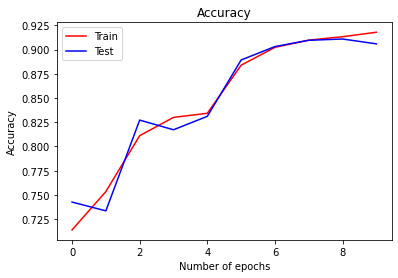

In [22]:
plt.plot(history.history["accuracy"], color = "red", label = "Train")
plt.plot(history.history["val_accuracy"], color = "blue", label = "Test")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title(f"Accuracy")
plt.legend()
plt.show()

Calculate the overall loss and accuracy at the end of the training

In [23]:
evaluate_model(model, "train", train_ds)

675/675 - 110s - loss: 1.5374 - accuracy: 0.9236


INFO:root:For train: loss=1.537, accuracy=0.924


In [24]:
evaluate_model(model, "validation", valid_ds)

169/169 - 28s - loss: 1.5556 - accuracy: 0.9059


INFO:root:For validation: loss=1.556, accuracy=0.906


The validation dataset performs slightly worse than the train dataset, as expected.

The overall accuracy is above 90%, so quite good performance for only 10 epochs.

Loss should be as low as possible (min value is 0.0). The validation loss starts to increase at epoch 8, then decreases slightly. 
Same for the accuracy which be as high as possible (max value is 1.0). It starts to decrease around epoch 8, then increases slightly. 

So it seems that we start to overtrain. We already used a dropout layer as a regularization to avoid overtraining and we could add more in the future when running with more epochs.

## 4.3 Save the model to a file to be used later for predictions in production.

In [25]:
model.save(MODEL_FILE_NAME)

## 4.4 Predict labels for the datasets in train and test and compare with the true labels

In [29]:
labels_true_train, labels_pred_train = predict(model, "train", train_ds, BATCH_SIZE)
evaluate_confusion_matrix("train", labels_true_train, labels_pred_train, OUTPUT_FOLDER_NAME)

INFO:root:Running inference on the entire dataset of type train. This may take a few minutes ...
INFO:root:Printing out the labels true and predicted for the first 5 images.
INFO:root:The train dataset has 675 batches of images, each with a batch_size=32, for a total of 21600 images.
INFO:root:i=0
INFO:root:0, true, shape=(32,), [8 4 5 7 1 1 9 7 6 9 5 2 9 9 7 4 4 0 0 6 2 9 4 4 5 4 6 5 2 2 4 8]
INFO:root:0, pred, shape=(32,), [2 4 5 7 1 1 9 7 6 9 5 2 9 9 7 4 4 0 0 6 2 9 4 4 5 4 6 5 2 2 4 8]
INFO:root:1, true, shape=(32,), [4 7 6 4 2 7 1 0 0 2 7 3 9 5 4 7 5 4 6 1 5 2 1 5 1 6 4 6 9 1 9 5]
INFO:root:1, pred, shape=(32,), [4 7 6 4 2 7 1 0 0 2 7 3 9 5 4 7 5 4 6 1 5 2 1 5 1 6 4 6 9 1 9 5]
INFO:root:2, true, shape=(32,), [3 8 4 3 0 9 5 2 3 0 1 5 9 6 0 9 1 3 9 0 7 5 2 0 7 4 2 3 2 4 8 2]
INFO:root:2, pred, shape=(32,), [3 8 4 3 0 9 5 2 7 0 1 1 9 6 0 9 1 3 9 0 7 5 2 0 7 4 2 3 2 4 8 2]
INFO:root:3, true, shape=(32,), [1 1 7 1 5 9 9 3 6 6 3 7 5 7 8 7 3 3 9 1 2 5 0 0 0 8 9 3 9 1 1 2]
INFO:root:3, pr

In [30]:
labels_true_valid, labels_pred_valid = predict(model, "validation", valid_ds, BATCH_SIZE)
evaluate_confusion_matrix("validation", labels_true_valid, labels_pred_valid, OUTPUT_FOLDER_NAME)

INFO:root:Running inference on the entire dataset of type validation. This may take a few minutes ...
INFO:root:Printing out the labels true and predicted for the first 5 images.
INFO:root:The validation dataset has 169 batches of images, each with a batch_size=32, for a total of 5408 images.
INFO:root:i=0
INFO:root:0, true, shape=(32,), [3 9 9 2 4 5 0 1 3 2 1 1 3 0 2 4 4 0 3 8 3 2 7 4 8 8 6 7 7 7 0 9]
INFO:root:0, pred, shape=(32,), [3 9 9 2 4 5 0 1 3 2 1 1 8 0 2 4 4 0 3 8 2 2 7 4 8 8 6 7 7 7 0 9]
INFO:root:1, true, shape=(32,), [2 2 9 8 8 0 8 6 8 6 8 4 9 3 2 0 2 9 5 9 0 6 8 2 6 6 5 9 3 3 1 6]
INFO:root:1, pred, shape=(32,), [2 2 9 8 8 0 8 6 8 6 8 4 9 4 2 0 2 9 5 9 0 6 8 2 6 6 5 9 3 6 1 6]
INFO:root:2, true, shape=(32,), [9 7 9 7 4 7 4 1 0 0 7 3 8 7 1 1 8 1 0 7 6 4 5 9 2 9 6 4 4 7 1 6]
INFO:root:2, pred, shape=(32,), [9 7 9 7 4 7 4 1 0 0 7 3 8 7 1 1 8 1 0 7 6 4 5 9 6 9 6 4 4 7 1 7]
INFO:root:3, true, shape=(32,), [7 2 8 3 6 0 1 3 5 7 3 1 8 7 3 9 5 5 3 7 4 8 8 4 1 2 7 4 4 9 0 0]
INFO:r

In [31]:
labels_true_train.shape

(21600,)

In [32]:
labels_pred_train.shape

(21600,)

In [33]:
labels_true_valid.shape

(5400,)

In [34]:
labels_pred_valid.shape

(5400,)

Both Train and Validation look very good, with the matrix mostly diagonal, consistent with our accuracy values of above 90%. 

# 5. Predict from the stored model, as in production

## 5.1 Recreate an empty model and load the learned weights

In [35]:
model_2 = get_model(input_shape, data_augmentation, normalization_layer, base_model, num_classes)
model_2.load_weights(MODEL_FILE_NAME)

INFO:root:None


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## 5.2 Predict on a given image

In [36]:
image_file_name = f"{INPUT_FOLDER_NAME}/Highway/Highway_624.jpg"
predict_for_an_image(model, image_file_name, list_class_name, image_size)

INFO:root:(64, 64, 3)
INFO:root:(1, 64, 64, 3)
INFO:root:Sum of fractions for predictions is indeed 1.0 (within rounding errors), as sum = 1.0
INFO:root:Class name: AnnualCrop           prediction: 0.000
INFO:root:Class name: Forest               prediction: 0.000
INFO:root:Class name: HerbaceousVegetation prediction: 0.000
INFO:root:Class name: Highway              prediction: 1.000
INFO:root:Class name: Industrial           prediction: 0.000
INFO:root:Class name: Pasture              prediction: 0.000
INFO:root:Class name: PermanentCrop        prediction: 0.000
INFO:root:Class name: Residential          prediction: 0.000
INFO:root:Class name: River                prediction: 0.000
INFO:root:Class name: SeaLake              prediction: 0.000
INFO:root:Predicted class is Highway.


## 5.3 Predict on images taking from the validation dataset

In [39]:
predict_for_a_batch(model, list_class_name, "validation", valid_ds, index_batch = 1, output_folder_name = OUTPUT_FOLDER_NAME)

## 5.4 Discussion about production

For production we would move the part about the prediction from a new dataset in a standalone python script, as in the attached `interface.py` and `utils.py`. Some plots with their prediction will be shown in the `./output` folder.